# Project: Dynamics of Bargaining Pwer
# Multi Objective Dynamic Model (dynamics of bargaining power)

#### Genaro, Itza, Sonia
#### May 2021 

This code was made specifically to solve the dynamic multi-objective model of principal-agent proposed by ... 

This aplication uses the JuMP library and the Ipopt solver to solve the one-step optimization problrem for the Belman Ecuation and a loop to find the stationary value for the state variable.

The use uf this library allows us to easily change the parametrization of the problem and rely on a robust solver to find solutions in multi-criteria non-linear restricted optimization problems. 

## Libraries

In [1]:
using DataFrames
using XLSX
using JuMP # Loading optimization libraries.
using Ipopt # Ipopt solve a nonlinear optimization problem.
using ExcelFiles  # Loading excel files libraries.

## Utility Functions

In [13]:
#v(c,a,g=1,alpha=1)=-exp(g*(a-alpha*c))  # Declaration of v (agent utility function); 
                                        # g is the coefficient of risk aversion
                                        # alpha is a cost coefficientv

v(c, a, h=0.5) =  c^(1-h)/(1-h)- a^2 #CRA Function 
                                    #h is a oefficient of risk aversion
                                    # a is the agent effort
u(y,w)=y-w  #Declaration of the principal utility function 
            #y is the current output
            #w is the salary paid to the agent

u (generic function with 1 method)

## High Effort Model Specification 

In [14]:
function Model_High_Effort(h, delta, P, Q, U0, V)
    """
    This functions declares and solves the High effort model for the weighted sum of agent and principal utilities 
    Returns optimal values if found 
    """
    model_high_effort = Model(
            with_optimizer(
                Ipopt.Optimizer, 
                tol = 1e-7, 
                max_iter = 1000, 
                print_level=1)) 

    # Declare the decision variables for the model: xl = wl, xh = wh.
    @variable(model_high_effort, xl >= 0.00001)  # xl = wl, low compensation.
    @variable(model_high_effort, xh >= 0.00001)  # xh = wh, hight compensation.

    # Declare the agent's utility function within the model.
    register(model_high_effort, :v, 3, v, autodiff=true)    # m, the model name
                                            # :v,  **********                                          
                                            # 2, number of variables
                                            # v, declare the agent's utility function 
                                            # autodiff,    **********
    register(model_high_effort, :u, 2, u, autodiff=true) 

    # Non-linear type expressions are declared, the expected utility of the agent, within the model. 
    EV_H = @NLexpression(model_high_effort, f[1,1]*(v(xh,A[2], h)+beta*V[P])+f[1,2]*(v(xl,A[2],h)+beta*V[Q]))    # E(v|ah)
    EV_L = @NLexpression(model_high_effort, f[2,1]*(v(xh,A[1],h)+beta*V[P])+f[2,2]*(v(xl,A[1],h)+beta*V[Q]))    # E(v|al)
    EU_H = @NLexpression(model_high_effort, f[1,1]*(u(Y[2],xh)+beta*U0[P])+f[1,2]*(u(Y[1],xl)+beta*U0[Q])) #E(U|ah)

    # Objective function; expected utility of the principal and the agent given ah.
    @NLobjective(model_high_effort, Max, delta*EV_H+(1-delta)*EU_H ) 

    @constraint(model_high_effort, xh<=Y[2])  # Financial capacity restriction for high compensation; wh<=yh.
    @constraint(model_high_effort, xl<=Y[1])  # Financial capacity restriction for low compensation; wl<=yl.

    @NLconstraint(model_high_effort, EV_H >= EV_L) # Incentive constraint to incentivize ah.
    
    # The problem for incentive ah is solved.
    JuMP.optimize!(model_high_effort) 
    
    #The optimal values are saved and returned
    wh = value(xh)
    wl = value(xl)
    uh = f[1,1]*(u(Y[2],wh)+beta*U0[P])+f[1,2]*(u(Y[1],wl)+beta*U0[Q])
    vh = f[1,1]*(v(wh,A[2], h)+beta*V[P])+f[1,2]*(v(wl,A[2],h)+beta*V[Q])
    return uh, vh, wl, wh, termination_status(model_high_effort)
end

Model_High_Effort (generic function with 1 method)

## Low Effort Model Specification

In [15]:
function Model_Low_Effort(h, delta, P, Q, U0, V)
    """
    This functions declares and solves the Low effort model for the weighted sum of agent and principal utilities 
    Returns optimal values if found 
    """
    model_low_effort = Model(
        with_optimizer(
            Ipopt.Optimizer, 
            tol = 1e-7, 
            max_iter = 1000,
            print_level=1))

    # Declare the decision variables for the model: xl = wl, xh = wh.
    @variable(model_low_effort, xl >= 0.00001)  # xl = wl, low compensation.
    @variable(model_low_effort, xh >= 0.00001)  # xh = wh, hight compensation.

    # Declare the agent's utility function within the model.
    register(model_low_effort, :v, 3, v, autodiff=true)    # m, the model name
                                            # :v,  **********                                          
                                            # 2, number of variables
                                            # v, declare the agent's utility function 
                                            # autodiff,    **********

    register(model_low_effort, :u, 2, u, autodiff=true) 
    
    # Non-linear type expressions are declared, the expected utility of the agent, within the model. 
    EV_H = @NLexpression(model_low_effort, f[1,1]*(v(xh,A[2], h)+beta*V[P])+f[1,2]*(v(xl,A[2],h)+beta*V[Q]))    # E(v|ah)
    EV_L = @NLexpression(model_low_effort, f[2,1]*(v(xh,A[1],h)+beta*V[P])+f[2,2]*(v(xl,A[1],h)+beta*V[Q]))    # E(v|al)
    EU_L = @NLexpression(model_low_effort,  f[2,1]*(u(Y[2],xh)+beta*U0[P])+f[2,2]*(u(Y[1],xl)+beta*U0[Q])) #E(U|al)

    # Objective function; expected utility of the principal given al.
    @NLobjective(model_low_effort, Max, delta*EV_L+(1-delta)*EU_L) 

    @constraint(model_low_effort, xh <= Y[2]) # Financial capacity restriction for high compensation; wh<=yh.
    @constraint(model_low_effort, xl <= Y[1]) # Financial capacity restriction for low compensation; wl<=yl.

    @NLconstraint(model_low_effort, EV_H <= EV_L)  # Incentive constraint to incentivize al.

    # The problem posed for incentive al is solved.
    JuMP.optimize!(model_low_effort)

    # The optimal value of the function is saved given al and returned.
    wh = value(xh)
    wl = value(xl)
    ul = f[2,1]*(u(Y[2],wh)+beta*U0[P])+f[2,2]*(u(Y[1],wl)+beta*U0[Q])
    vl = f[2,1]*(v(wh,A[1], h)+beta*V[P]) + f[2,2]*(v(wl,A[1],h)+beta*V[Q])
    
    return ul, vl, wl, wh, termination_status(model_low_effort) 
end

Model_Low_Effort (generic function with 1 method)

### Feasable Bargaining Powers

In [16]:
function min_delta(h)
    """
    This function returns the minimun bargaining porwer of the agent that guarantees interior solutions
    """
    delta = 0 
    #Solve high effort for delta_0 = 0
    uh, vh, xl, xh, stat_high = Model_High_Effort(h, delta, 1, 1, zeros(1), zeros(1))
    #Solve low eefort for delta_0 = 0
    ul, vl, xl, xh, stat_low = Model_Low_Effort(h, delta, 1, 1, zeros(1), zeros(1))
    #Choose the model that optimizes the weighted utility sum. 
    if delta*vh+(1-delta)*uh>delta*vl+(1-delta)*ul
            v = vh
        else
            v = vl 
        end
    vf = copy(v) 
    #Search delta_t such that we find interior solution 
    while round.(v,digits = 5) == round.(vf,digits = 5)
        delta += 0.01 #Update delta_t
        #Solve high effort for delta_t
        uh, vh, xl, xh, stat_high = Model_High_Effort(h, delta, 1, 1, zeros(1), zeros(1))
        #Solve low effort for delta_t
        ul, vl, xl, xh, stat_low = Model_Low_Effort(h, delta, 1, 1, zeros(1), zeros(1))
        #Choose the model that optimizes the weighted utility sum.
        if delta*vh+(1-delta)*uh>delta*vl+(1-delta)*ul
            vf = vh
        else
            vf = vl 
        end
    end
    return delta - 0.01 #Return delta_min 
end


function max_delta(h)
    """
    This function returns the maximum bargaining porwer of the agent that guarantees interior solutions
    """
    delta = 1
    #Solve high effort for delta_0 = 1
    uh, vh, xl, xh, stat_high = Model_High_Effort(h, delta, 1, 1, zeros(1), zeros(1))
    #Solve low effort for delta_0 = 1
    ul, vl, xl, xh, stat_low = Model_Low_Effort(h, delta, 1, 1, zeros(1), zeros(1))
    #Choose the model that optimizes the weighted utility sum.
    if delta*vh+(1-delta)*uh>delta*vl+(1-delta)*ul
        v = vh
    else
        v = vl 
    end
    vf = copy(v)
    #Search delta_t such that we find interior solution 
    while round.(v,digits = 5) == round.(vf,digits = 5)
        delta -= 0.01
        #Solve high effort for delta_t
        uh, vh, xl, xh, stat_high = Model_High_Effort(h, delta, 1, 1, zeros(1),zeros(1))
        #Solve low effort for delta_t
        ul, vl, xl, xh, stat_low = Model_Low_Effort(h, delta, 1, 1, zeros(1), zeros(1))
        #Choose the model that optimizes the weighted utility sum.
        if delta*vh+(1-delta)*uh>delta*vl+(1-delta)*ul
            vf = vh
        else
            vf = vl 
        end
    end
    return delta+0.01 #return delta_max
end

max_delta (generic function with 1 method)

## Variables and Lists

In [ ]:
A = [0.1 0.2]    # Actions set [al ah]
Y = [0.4 0.8]    # Outcomes set [yl yh]
f = [2/3 1/3; 1/3 2/3]    # Probability matrix  [yh|ah yl|ah; yh|al yl|al]
beta = 0.96    # Future discount factor
h = 0.5 #Risk AdversionParameter for agent utility 
digits_tol = 3 #Digits of precision 
Max_iter = 300 #Limit of method iterations
dl = min_delta(h) #Min bargaining power
dh = max_delta(h) #Max bargaining power
println(dl,dh)
eps = 0.005 #Dynamic of the bargaining power parameter 
n = trunc(Int, ceil((dh-dl)*(2/eps)+1)) #Bargaining power number of intervals
V = zeros(n) # State variable's initial value vector  
VF =  zeros(n) # State variable's final value vector  
UF = zeros(n) # List of final values of the principal utility
U0 = ones(n) # State variable's initial value
Deltas = LinRange(round(dl, digits = 2), round(dh, digits = 2),n) #List of admisible bargaining powers

## Routine 

In [11]:
function Dynamic_Pareto_Frontier(Deltas, n, V, VF, U0, UF, digits_tol, Max_iter, h)
    """
    This functions finds the stationary point of the Bellman Equation for 
    the multi objective dynamic model with bargaining power dynamics
    Returns optimal values if found 
    """
    iter=0 #numero de iteraciones para enontrar el punto estacionario 
    AcOpt = [] # List of optimal actions for K
    WHOpt = [] # List of hight optimal compensation for K
    WLOpt = [] # List of low optimal compensation for K
    DFH=ones(n).*n #List of next period promised bargaining power if output yh occurs
    DFL=ones(n) #List of next period promised bargaining power if output yl occurs

    while round.(U0,digits = digits_tol)!=round.(UF,digits = digits_tol)  #loop to find thestationary point of the principal Utility
    
        AcOpt=[] # List of optimal actions for K
        WHOpt=[] # List of hight optimal compensation for K
        WLOpt=[] # List of low optimal compensation for K
        U0=UF #Update of the state variable (Princial Utility)
        V = VF #Update of the state variable (Agent Utility)
        UF=zeros(n) #Inital Value in the loop for Princial Utility
        VF = zeros(n) #Inital Value in the loop for Agent Utility
        
        for d in 1:n #Loop for bargaining powers
            
            delta = Deltas[d] #Current bargaining power
            uval = -10000 #Initialization of the agent utility for the current bargaining power
            vval = -10000 #Initialization of the principal utility for the current bargaining power
            wl=0 #Initialization of the low compensation for the current bargaining power
            wh=0 #Initialization of the high compensation for the current bargaining power
            accopt=0 #Initialization of the recomended effort for the current bargaining power
            p=0 #Initialization of the promised bargaining power|yh 
            q=0 #Initialization of the promised bargaining power|yl
            val = -10000 #Initialization of the weighted sum of the agent and pricial's utilities for the current bargaining power
            P = min(d+2, n) #Index for the next period bargaining power if output yh is observed
            Q = max(d-1, 1) #Index for the next period bargaining power if output yl is observed
                    
            #Solve the model for high effort given the current bargaining power
            uh, vh, xl, xh, stat_high = Model_High_Effort(h, delta, P, Q, U0, V) 

            #If the weighted sum of utilities is higher than it's last value
            if (delta*vh+(1-delta)*uh>val) & (stat_high == MOI.LOCALLY_SOLVED) 
                val = delta*vh+(1-delta)*uh #Update sum of utilities 
                uval=uh #Update optimal value for the princial utility
                vval = vh #Update optimal value for the agent utility
                wh=xh #Update optimal value for the high compensation 
                wl=xl #Update optimal value for the low compensation
                accopt=A[2] #Udate optimal reccomended action                       
            end

            #Solve the model for low effort given the current bargaining power
            ul, vl, xl, xh, stat_low = Model_Low_Effort(h, delta, P, Q, U0, V)

            #If the weighted sum of utilities is higher than it's last value
            if (delta*vl+(1-delta)*ul>val) & (stat_low == MOI.LOCALLY_SOLVED)
                val=delta*vl+(1-delta)*ul #Update sum of utilities 
                uval=ul #Update optimal value for the princial utility
                vval = vl #Update optimal value for the agent utility
                wh=xh #Update optimal value for the high compensation 
                wl=xl #Update optimal value for the low compensation
                accopt=A[1] #Udate optimal reccomended action 
            end
            
            #Save all optimal values for the current bargaining power
            UF[d] = uval 
            VF[d] = vval 
            append!(WHOpt, wh)
            append!(WLOpt,wl)
            append!(AcOpt, accopt)
            DFH[d] = P
            DFL[d] = Q
            
            if iter<=1 
                #Print Results
                println(iter)
                #print("Delta= ", delta, "  u=", uval,"   wh=", wh, "   wl=", wl, "  P=",P,"  Q=",Q,"  Acc= ", accopt, "\n")
            end
        end
        
        iter+=1 #Update iteration counter
        #println(iter) #Print current iteration 
        
        if iter == Max_iter #If number of iteration reaches max, finish the method.
            break
        end

    end
    #Save stationary result of all variables in dataframe 
    DataEstPoint = DataFrame(
    Deltas = Deltas,
    Utilidad_Agente=VF,
    Utilidad_Principal=UF,
    Compensacion_YH=WHOpt,
    Compensacion_YL=WLOpt,
    Accion_Recomendada=AcOpt, 
    DFH=DFH, 
    DFL=DFL)
    
    return DataEstPoint #Return Dataframe 
end

Dynamic_Pareto_Frontier (generic function with 1 method)

In [ ]:
H = [0.10, 0.25,0.50,0.75,0.90]
for h in H
    A = [0.1 0.2]    # Actions set [al ah]
    Y = [0.4 0.8]    # Outcomes set [yl yh]
    f = [2/3 1/3; 1/3 2/3]    # Probability matrix  [yh|ah yl|ah; yh|al yl|al]
    beta = 0.96    # Future discount factor
    digits_tol = 3 #Digits of precision 
    Max_iter = 300 #Limit of method iterations
    dl = min_delta(h) #Min bargaining power
    dh = max_delta(h) #Max bargaining power
    println(dl,dh)
    eps = 0.005 #Dynamic of the bargaining power parameter 
    n = trunc(Int, ceil((dh-dl)*(2/eps)+1)) #Bargaining power number of intervals
    V = zeros(n) # State variable's initial value vector  
    VF =  zeros(n) # State variable's final value vector  
    UF = zeros(n) # List of final values of the principal utility
    U0 = ones(n) # State variable's initial value
    Deltas = LinRange(round(dl, digits = 2), round(dh, digits = 2),n) #List of admisible bargaining powers
    DataEstPoint_MOWS = Dynamic_Pareto_Frontier(Deltas, n, V, VF, U0, UF, digits_tol, Max_iter, h) 
    save(string("CRA/Dynamic_Bargaining_Power/CRA_h",repr(h),"eps005.xlsx"), DataEstPoint_MOWS) #Save data of stationary point to excel
end

In [8]:
#Execution of the method
DataEstPoint_MOWS = Dynamic_Pareto_Frontier(Deltas, n, V, VF, U0, UF, digits_tol, Max_iter, h) 
save("Wangs Utility Function/Bargaining_Dynamic/Wang_eps005.xlsx", DataEstPoint_MOWS) #Save data of stationary point to excel

Delta= 0.41  u=0.5333233333333334   wh=1.0e-5   wl=1.0e-5  P=3  Q=1  Acc= 0.1
Delta= 0.4125  u=0.5333233333333334   wh=1.0e-5   wl=1.0e-5  P=4  Q=1  Acc= 0.1
Delta= 0.415  u=0.4653064415839759   wh=0.30203533762403617   wl=1.0e-5  P=5  Q=2  Acc= 0.2
Delta= 0.4175  u=0.46530644157731793   wh=0.3020353376340231   wl=1.0e-5  P=6  Q=3  Acc= 0.2
Delta= 0.42  u=0.4653064416050498   wh=0.3020353375924253   wl=1.0e-5  P=7  Q=4  Acc= 0.2
Delta= 0.4225  u=0.46530644159911055   wh=0.30203533760133416   wl=1.0e-5  P=8  Q=5  Acc= 0.2
Delta= 0.425  u=0.46530644146179795   wh=0.3020353378073031   wl=1.0e-5  P=9  Q=6  Acc= 0.2
Delta= 0.4275  u=0.46530644144147165   wh=0.3020353378377926   wl=1.0e-5  P=10  Q=7  Acc= 0.2
Delta= 0.42999999999999994  u=0.4653064414739632   wh=0.3020353377890552   wl=1.0e-5  P=11  Q=8  Acc= 0.2
Delta= 0.4325  u=0.465306441418368   wh=0.302035337872448   wl=1.0e-5  P=12  Q=9  Acc= 0.2
Delta= 0.43500000000000005  u=0.46530644099774365   wh=0.30203533850338454   wl=1.0e-5  P=

## Plotting

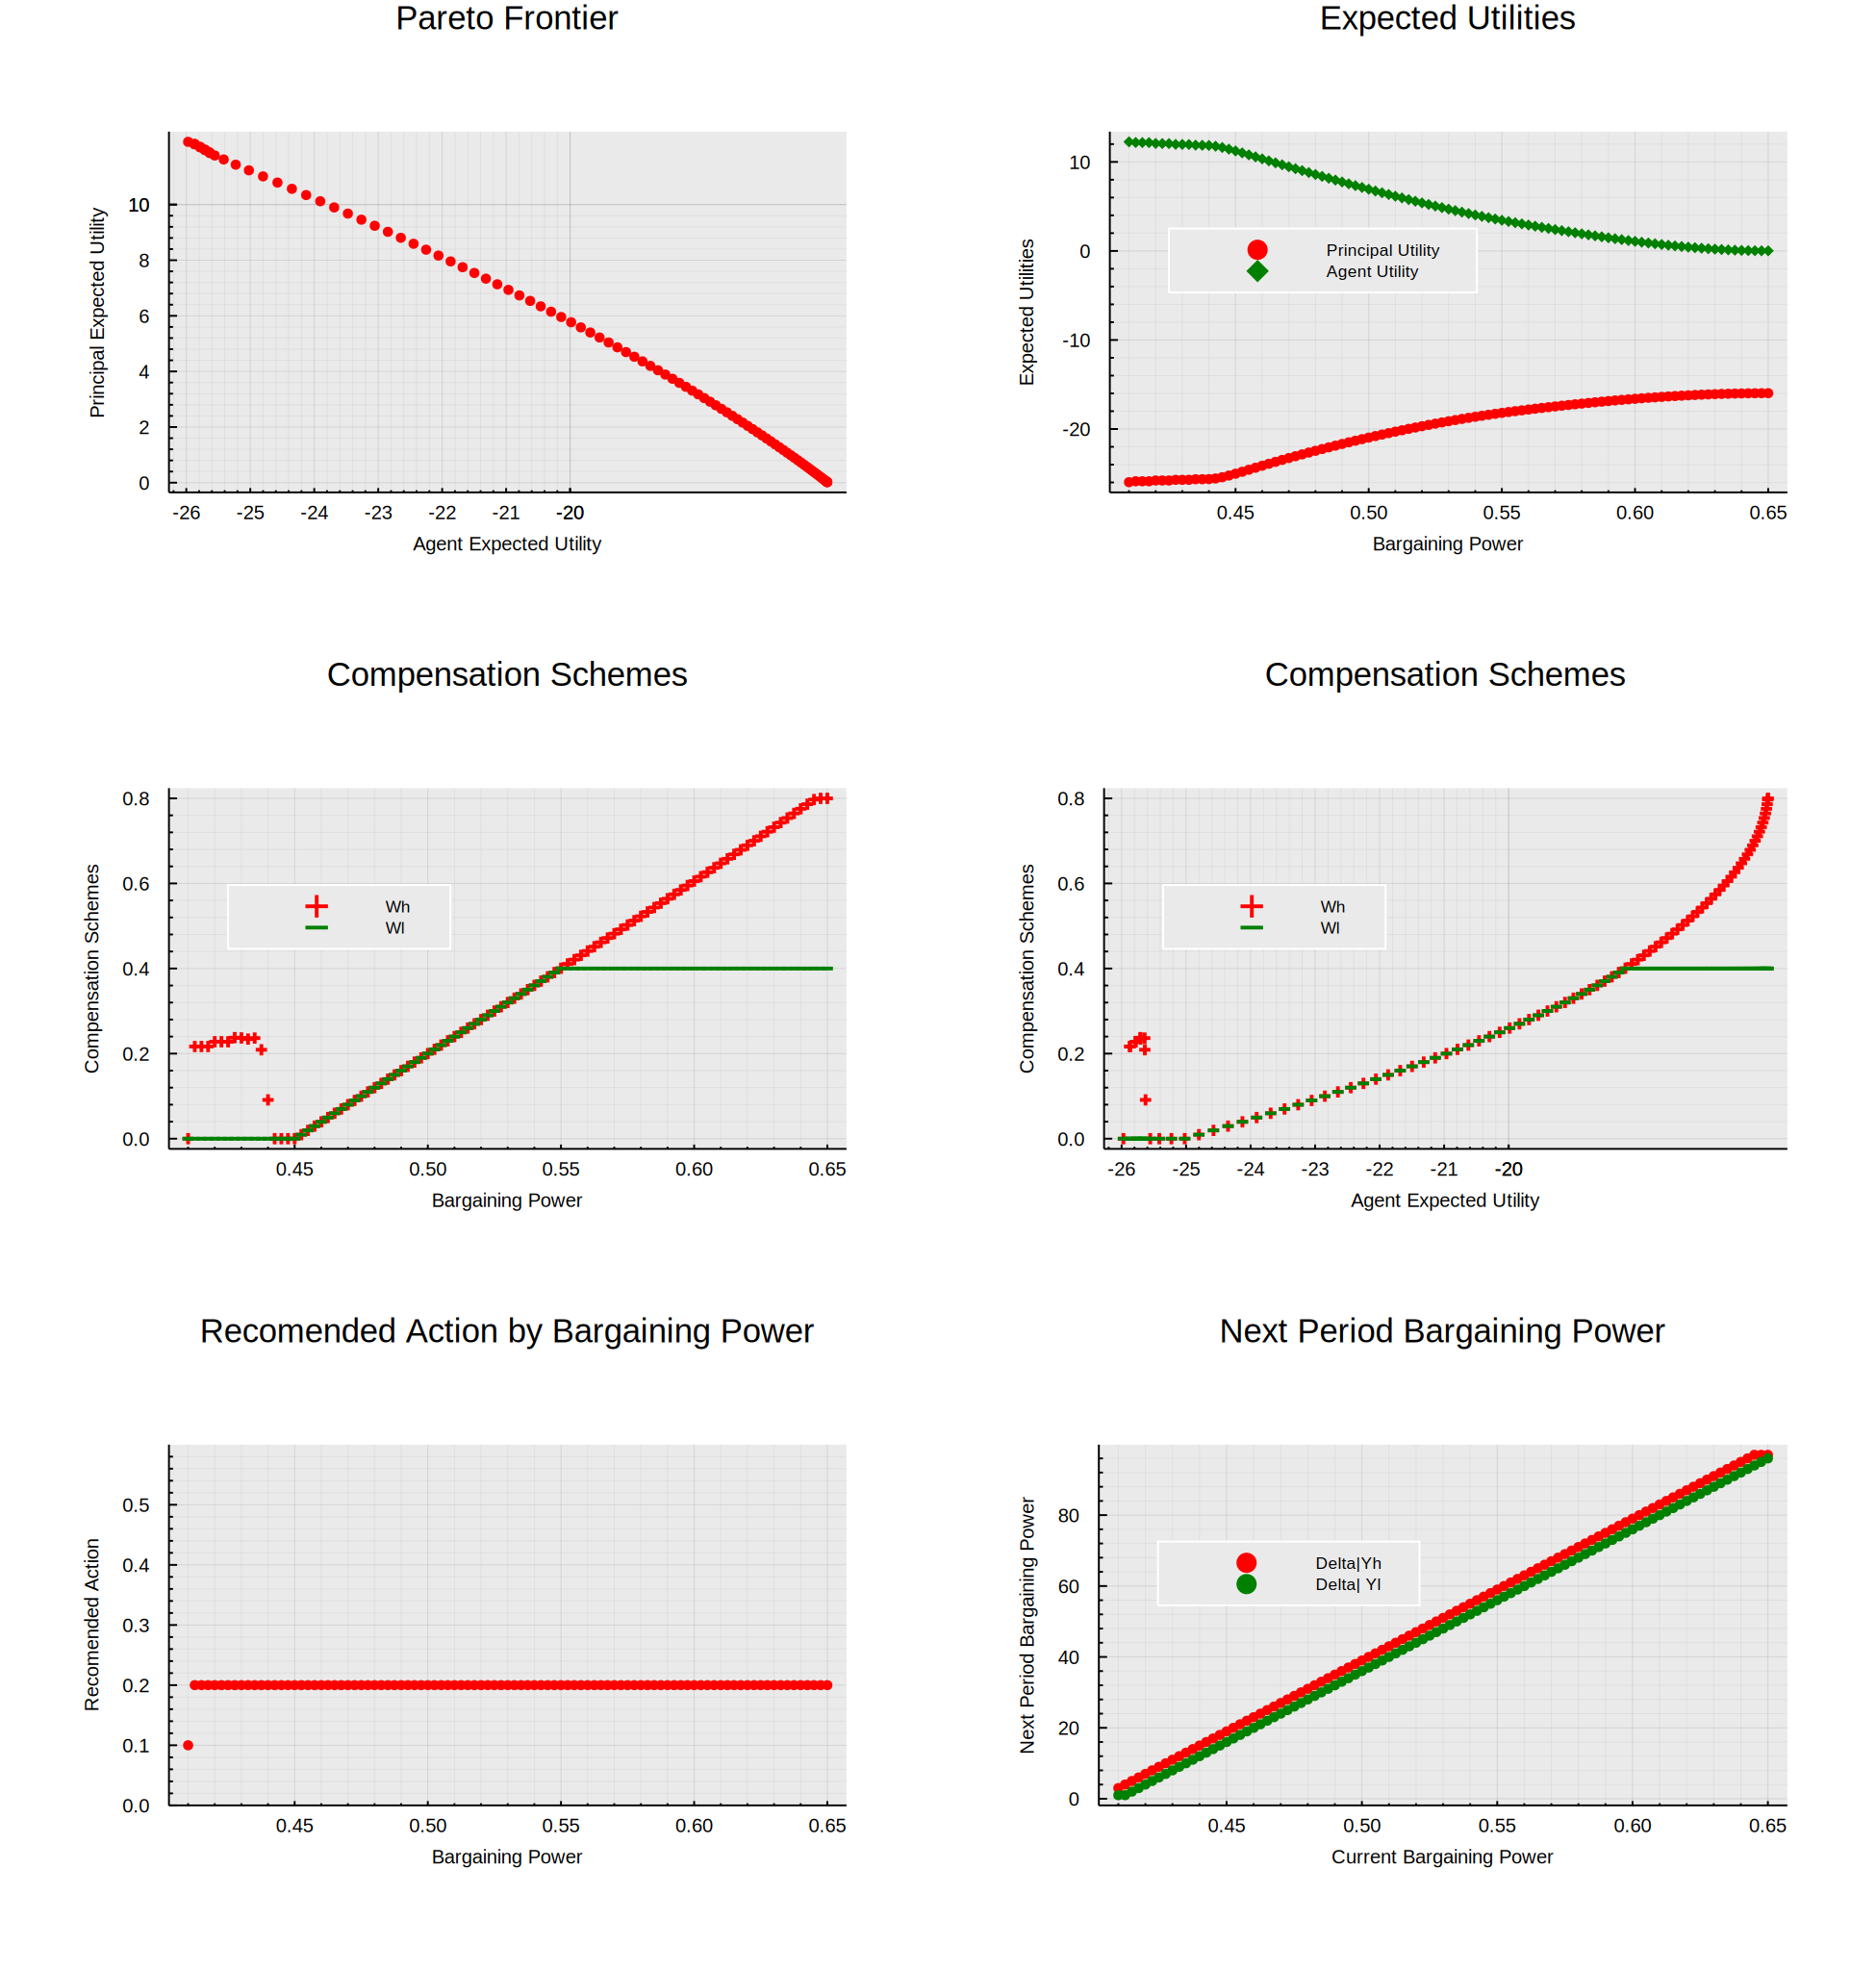

In [10]:
using Plots, Plots.PlotMeasures    # Plots packages load
theme(:ggplot2)     # Graphics theme

#Read data to plot 
DataEstPoint_MOWS = DataFrame(XLSX.readtable("Wangs Utility Function/Bargaining_Dynamic/Wang_eps005.xlsx", "Sheet1")...)

#Recomended Action by bargaining power plot.
pl1=scatter(DataEstPoint_MOWS[:, "Deltas"], DataEstPoint_MOWS[:, "Accion_Recomendada"], 
    color = [:red],
    legend = false,
    title = "Recomended Action by Bargaining Power", 
    xlabel = "Bargaining Power",
    ylabel =  "Recomended Action", 
    ylims = (0,0.6))

#Pareto Frontier Plot 
pl2=scatter(DataEstPoint_MOWS[:, "Utilidad_Agente"], DataEstPoint_MOWS[:, "Utilidad_Principal"],
    color = [:red],
    legend = false,
    title = "Pareto Frontier", 
    xlabel = "Agent Expected Utility",
    ylabel =  "Principal Expected Utility") 

#Compensation Schemes by bargaining power plot. 
pl3=scatter([DataEstPoint_MOWS[:, "Deltas"], DataEstPoint_MOWS[:, "Deltas"]], [DataEstPoint_MOWS[:, "Compensacion_YH"], DataEstPoint_MOWS[:, "Compensacion_YL"]],
    color = [:red :green],
    shape = [:+ :hline :utri],
    labels = ["Wh" "Wl"],
    legend = :topleft,
    title = "Compensation Schemes", 
    xlabel = "Bargaining Power",
    ylabel =  "Compensation Schemes")

#Compensation Schemes by agent utility plot. 
pl4=scatter([DataEstPoint_MOWS[:, "Utilidad_Agente"], DataEstPoint_MOWS[:, "Utilidad_Agente"]], [DataEstPoint_MOWS[:, "Compensacion_YH"], DataEstPoint_MOWS[:, "Compensacion_YL"]],
    color = [:red :green],
    shape = [:+ :hline :utri],
    labels = ["Wh" "Wl"],
    legend = :topleft,
    title = "Compensation Schemes", 
    xlabel = "Agent Expected Utility",
    ylabel =  "Compensation Schemes")

#Expected Agent and Principal utilities plot.
pl5=scatter([DataEstPoint_MOWS[:, "Deltas"], DataEstPoint_MOWS[:, "Deltas"]], [DataEstPoint_MOWS[:, "Utilidad_Agente"], DataEstPoint_MOWS[:, "Utilidad_Principal"]],
    color = [:red :green],
    shape = [:circle :diamond :utri],
    labels = ["Principal Utility" "Agent Utility"],
    legend = :topleft,
    title = "Expected Utilities", 
    xlabel = "Bargaining Power",
    ylabel =  "Expected Utilities", 
    markersize = 2)  

#Next Period bargaining powers plot.
pl6=scatter(
    [DataEstPoint_MOWS[:, 1], DataEstPoint_MOWS[:, 1]],
    [DataEstPoint_MOWS[:, "DFH"], DataEstPoint_MOWS[:, "DFL"]],
    #markersize = 2, 
    labels = ["Delta|Yh" "Delta| Yl"],
    color = [:red :green],
    title = "Next Period Bargaining Power", 
    legend = :topleft,
    xlabel = "Current Bargaining Power",
    ylabel =  "Next Period Bargaining Power") 

#Layout
l = @layout [a b; c d; e f]

#Figure 
complete_plot = plot(pl2, pl5, pl3, pl4, pl1, pl6, layout = l,
    size = (1000,1050),
    dpi = 1000,
    xtickfont = font(7), 
    ytickfont = font(7), 
    guidefont = font(7), 
    titlefont = font(12),
    legendfont = font(6),
    markersize = 3,
    margin = 10mm) 
display(complete_plot)

#Save figure 
savefig("Wangs Utility Function/Bargaining_Dynamic/Wang_eps005")